# Computer vision and deep learning - Laboratory 5

In this laboratory, you will continue the semantic segmentation mini-project that we started last time. More specifically, you will write the CNN architecture, define the training loop, perform hyperparameter search and evaluate the best segmentation module.

In [1]:
# !pip install wget
# !pip install wandb -qU

import os
import cv2
import wget
import glob
import wandb
import shutil
import numpy as np

import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import v2

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# !mkdir 'cvdl_lab_4'


In [3]:

#!cd cvdl_lab_4
#!pwd

## Building the model

The model that will be used in this laboratory is inspired by the [U-Net](https://arxiv.org/abs/1505.04597) architecture.
U-Net is a fully convolutional neural network comprising two symmetric paths: a contracting path (to capture context) and an expanding path  (which enables precise localization).
The network also uses skip connections between the corresponding layers in the downsampling path to the layer in the upsampling path, and thus directly fast-forwards high-resolution feature maps from the encoder to the decoder network.

The output of the model is an volume with depth C, where C is the number of pixel classes. For example, if you want to classify the pixels into person and background, the output will be a volume of depth 2.
If you want to classify the pixels into face, hair and background the output will be a volume of depth 3.

**Read the U-Net paper and try to understand the architecture.**

An overview of the U-Net architecture is depicted in the figure below:
<img src="https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png"/>




## The upsamping path


In the upsampling path, we'll use transposed convolutions to progressively increase the resolution of the activation maps. The layers for the transposed convolution is [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

Let's write a function to implement an upsampling block, consisting of a transposed convolution, a batch normalization block and a ReLu activation.

Remember, the output size $W_o$ of a transposed convolutional layer is:  
\begin{equation}
W_o = (W_i - 1) \cdot S - 2P + F
\end{equation},

where $W_i$ is the size of the input, $S$ is the stride, $P$ is the amount of padding and $F$ is the filter size.


In [4]:
import torch
def upsample_block(x, filters, size, stride = 2):
  """
  x - the input of the upsample block
  filters - the number of filters to be applied
  size - the size of the filters
  """

  # TODO your code here
  # transposed convolution
  # BN
  # relu activation
  conv_2d = torch.nn.Conv2d(x.shape[1], out_channels=filters, kernel_size=size, stride=stride, bias=False)
  batch_norm_2d = torch.nn.BatchNorm2d(filters)
  relu = torch.nn.ReLU(inplace=True)
  
  return relu(batch_norm_2d(conv_2d(x)))

Now let's test this upsampling block

In [5]:
in_layer = torch.rand((32, 32, 128, 128))

filter_sz = 4
num_filters = 16

for stride in [2, 4, 8]:
  x = upsample_block(in_layer, num_filters, filter_sz, stride)
  print('in shape: ', in_layer.shape, ' upsample with filter size ', filter_sz, '; stride ', stride, ' -> out shape ', x.shape)

in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  2  -> out shape  torch.Size([32, 16, 63, 63])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  4  -> out shape  torch.Size([32, 16, 32, 32])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  8  -> out shape  torch.Size([32, 16, 16, 16])


## The down-sampling path


For the down-sampling path we'll use a classical convolutional neural network.

Write a class Encoder which inherits from ``torch.nn.Module`` for the down-sampling path. The model will be composed of several blocks, each block comprising two convolutional layers (with filter size of 3) with a ``ReLu`` non-linearity between them. The blocks of the encoder will be separated by max pooling layers with a size of 2 and a stride of 2.

 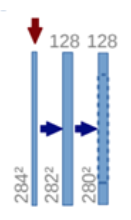

In the constructor of the Encoder class you will pass as parameter a list containing the number of channels used for each encoder block. In the forward function you will return a list containing the outputs of all the encoder blocks (you’ll be using them for the connection between the down-sampling path and the up-sampling path).

You can also use a pre-trained module from torchvision for this. You'll first load the pre-trained weights on ImageNet, and "freeze" these weights during the training process (set required_grad=False for those tensors). The problem is that to create the skip connections required by the U-Net architecture we need access to the feature maps of some intermediate layers in the network and these are not accessible by default.

You should inspect the implementation of the CNN that you chose, make the Encoder class inherit from the model you chose, and in the forward function, return the output of the layers you selected for the skip connections.



## The up-sampling path (Decoder)

In the upsampling path, we'll use transposed convolutions to progressively increase the resolution of the activation maps. The layers for the transposed convolution is [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

Let's write a function to implement an upsampling block, consisting of a transposed convolution, a batch normalization block and a ReLu activation.

Remember, the output size $W_o$ of a transposed convolutional layer is:  
\begin{equation}
W_o = (W_i - 1) \cdot S - 2P + F
\end{equation},

where $W_i$ is the size of the input, $S$ is the stride, $P$ is the amount of padding and $F$ is the filter size.


Similarly to the encoder, the decoder will be composed of several blocks, and each block will consist in a transposed convolution (followed by a batch normalization layer and a ReLU non-linearity) and then by an encoder block.  

 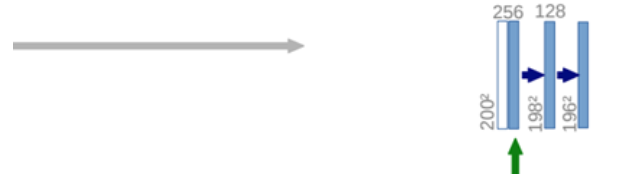

Write a class Decoder  which inherits from ``torch.nn.Module`` to implement the up-samping path; the constructor of this class will get as parameter the depth of each decoder module, and in the forward function you will have two parameters: the input feature map and a list of activations from the encoder (for the skip connections).  



In the forward function, for each block:

- apply the up-sampling operation (followed by batch normalization and ReLU);

- crop the corresponding activation map from the encoder (use CenterCrop) such that is has the same size as the decoder block;

- concatenate these two activation maps (on the channel dimension);

- apply an encoder block on the result;

- pass the result to the next decoder block.



## Putting it all together

Finally, you should write the UNet class which defines the semantic segmentation model. In this class you will use and connect the Encoder and Decoder classes that you previously wrote. The output of the segmentation module will be a volume with as many channels as the number of classes from the segmentation problem. Basically, each channel c from the output will be a map that stores the probability of each pixel to belong to the class c.

Apply a 1x1 convolution with c channels on the decoder output to obtain the segmentation map.

Finally, to have matching shapes between the network output (segmentation map) and the ground truth data, resize the segmentation map using ``torch.nn.functional.interpolate``.


### The training loop


Now, it’s time to write the training loop.  

You remember the steps from the previous labs. You need a train and a test DataLoader and you must first define the loss function BCELossWithLogits and select an optimizer.

Then:

- Get a batch of training data from the DataLoader
- Zero out the optimizer’s gradients
- Perform the forward pass
- Calculate and store the loss and the accuracy based on the predictions and the labels from the dataset
- Tell the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose
- Evaluate the model on the validation/test set. Store the loss and the accuracy on the validation/test set.

## Evaluation metrics

Finally, you will implement several segmentation metrics to evaluate the model you've just trained. As usual, try to implement these metrics without using any for loops.

In the remainder of this section we'll use the following notation:
- $n_{ij}$ - the total number of pixels classified to class
j but actually belonging to class i; $i, j \in 1, .., C$;
- $t_i = \sum_{j = 1}^{C} n_{ij}$ - the total number of pixels belonging to class $i$ (in the ground truth segmentation mask);
- $C$ - the total number of classes in the segmentation problem.

### Mean pixel accuracy

Pixel accuracy is the simplest image segmentation metric; it is defined as the percentage of pixels that were correctly classified by the model.

\begin{equation}
p_a = \frac{1}{C} \frac{\sum_{i}^{C} n_{ii}}{\sum_{i}^{C} t_i}
\end{equation}

This metric is not that relevant for class imbalanced problems (which occurs for most segmentation problems).

### Intersection over Union (IoU)

the intersection over union metric is defined as the ratio between the area of intersection and the area of union (between the predicted segmentation mask and the ground truth segmentation mask of a single class).
In case of a multi-class segmentation problem, we simple average the IoUs over all the classes. This metric is called mean Intersection over Union (mIou).

\begin{equation}
mIoU = \frac{1}{C} \sum_{i = 1}^{C} \frac{n_{ii}}{t_i - n_{ii} + \sum_{j = 1}^{C} n_{ji}}
\end{equation}

The ideal value for this metric is 1; usually values lower than 0.6 indicate a very bad performance.

### Frequency Weighted Intersection over Union

The frequency weighted over union metric is similar to mean IoU, but the values are weighted with the adequate frequencies of the pixels.

\begin{equation}
fIou = (\sum_{i = 1}^{k} t_i)^{-1}   \sum_{i = 1}^{C} t_i \cdot \frac{n_{ii}}{t_i - n_{ii} + \sum_{j = 1}^{C} n_{ji}}
\end{equation}

The values of this metric lie in the interval [0, 1], and the ideal value for this metric is 1.

Compute and report these metrics for your trained model(s).



# Wandb
Weights and Biases wandb is a machine learning experiment tracking and visualization tool which allows you to easily track, visualize, and collaborate on machine learning experiments. You will use wandb a to log and track various parameters, such as your hyperparameters, model performance metrics, data visualizations and system metrics.

For now, just check out this tutorial on how you can easily integrate wandb with pytorch. Just look at the functions from wandb and how they are used, such that next time you hvae an ideea on how to structure your project.

You will also use wandb sweeps to automate hyperparameter tuning. This module explores different combinations of hyperparameters to help users find the best configuration for their models. Sweep configurations can be defined using YAML files or programmatically in dictionaries, and wandb takes care of running multiple experiments with different parameter combinations, keeping track of results, and displaying them in a comprehensive dashboard for analysis.

This time you will use [wandb](https://wandb.ai/) to track your experiments and perform hyperparameter search.


1. Log the loss and several metrics after each epoch: use ``wandb.log()`` method within your training loop after each epoch to log the loss and at least two metrics on the train and the validation dataset.


2. Use a ``wandb.Table`` to visualize the predictions on the validation dataset across the training process. You can find more details [here](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/datasets-predictions/W%26B_Tables_Quickstart.ipynb#scrollTo=tbOiat0mrWA2).


3. [Artifacts](https://docs.wandb.ai/guides/artifacts/construct-an-artifact) are used to track and version any serialized data as the inputs and outputs.


"W&B Artifacts was designed to make it effortless to version your datasets and models, regardless of whether you want to store your files with W&B or whether you already have a bucket you want W&B to track. Once you've tracked your datasets or model files, W&B will automatically log each and every modification, giving you a complete and auditable history of changes to your files."


Create a class ModelCheckpoint which will be responsible for tracking the best N checkpoints across the training process. This class will monitor a metric, and if the value for that metric is higher/lower (depending on whether the ) than the current max/min, it will save a checkpoint of the model.
Also, you should ensure that at a given time only N checkpoints are being saved. So, if the number of saved checkpoints is greater than N, you should perform a cleanup.


```
    def __call__(self, model, epoch, metric_val):
        must_save = metric_val < self.best_metric_val if self.decreasing_metric else metric_val > self.best_metric_val
        if must_save:
            self.best_metric_val = metric_val
            # TODO use torch.save to save the model
            # TODO use the function below to log the model artifact
       
        # TODO if needed, perform cleanup
   
    def write_artifact(self, path, model_path, metric_val):
        artifact = wandb.Artifact(filename, type='model', metadata={'metric': metric_val})
        artifact.add_file(model_path)
        wandb.run.log_artifact(artifact)    


```


4. You will also use [wandb sweeps](https://docs.wandb.ai/guides/sweeps) to automate hyperparameter tuning. This module explores different combinations of hyperparameters to help users find the best configuration for their models.

[Here](https://www.youtube.com/watch?v=9zrmUIlScdY&ab_channel=Weights%26Biases) you can find a video tutorial on how you can use sweeps in wandb and [here](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb) the corresponding colab.


Random Search is a hyperparameter optimization technique that involves randomly sampling hyperparameter values within specified ranges or distributions. It explores the hyperparameter space by selecting combinations randomly, allowing for a broad search across various configurations without following a specific pattern or grid.


Grid Search is a method where hyperparameter values are exhaustively tested across a predefined grid or set of values. It evaluates the model's performance for each combination of hyperparameters within the specified ranges, systematically covering the entire search space to find the optimal configuration.


Perform hyperparameter search using wandb sweeps (more details [here](https://wandb.ai/wandb_fc/articles/reports/Running-Hyperparameter-Sweeps-to-Pick-the-Best-Model--Vmlldzo1NDQ0OTIy)) for the learning rate and at least one other parameter.
- first perform a random search as a preliminary exploration to identify "promising" values for your hyperparameters;
- then apply a grid search on this range, to perform a more focused investigation into promising regions for finer optimization.



In [ ]:
import wandb
from unet import UNet
from train import train
from segmentation_metrics import mean_pixel_accuracy, mean_intersection_over_union

sweep_config = {
  'method': 'bayes',
  'metric': {
    'name': 'loss',
    'goal': 'minimize',
  },
  'parameters': {
    'epochs': {
      'value': 15},
    'contrast': {
      'min': 0.1022,
      'max': 0.1236},
    'brightness': {
      'min': 0.1266,
      'max': 0.1666},
    'learning_rate': {
      'distribution': 'uniform',
      'min': 0.00839,
      'max': 0.008723
    },
    "batch_size": {"values": [14, 12, 10, 8]}
  },
  'transforms_brightness_and_contrast': True
}

sweep_id = wandb.sweep(sweep_config, project="wandb-experiment-sweep")  

# Create a WandB artifact for the model
model_artifact = wandb.Artifact("my_model", type="model")

unet, losses, accuracies, conf_matrix = None, None, None, None
def initiate_training(config: int = None):
  global unet, losses, accuracies, conf_matrix
  with wandb.init(
          # set the wandb project where this run will be logged
          project="final-project-cvdl",
          name="experiment-wandb-specialized",
          # track hyperparameters and run metadata
          config=sweep_config):
    config = wandb.config

    epochs = config.epochs
    lr = config.learning_rate
    bs = config.batch_size
    contrast = config.contrast
    brightness = config.brightness

    unet = UNet(in_channels=3, out_channels=3, kernel_size=3, features=[64, 128, 256, 512])
    losses, accuracies, conf_matrix = train(unet=unet, lr=lr, epochs=epochs, bs=bs, contrast=contrast, brightness=brightness, wandb=wandb)

wandb.agent(sweep_id, initiate_training, count=1)

# Save the trained PyTorch model to the artifact
torch.save(unet.state_dict(), "my_model.pth")
model_artifact.add_file("my_model.pth")


wandb.finish()

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('transforms_brightness_and_contrast' was unexpected)


Create sweep with ID: 2o0fr12z
Sweep URL: https://wandb.ai/soniamatei/wandb-experiment-sweep/sweeps/2o0fr12z


wandb: Agent Starting Run: 1gzf4ede with config:
wandb: 	batch_size: 12
wandb: 	brightness: 0.138399520743261
wandb: 	contrast: 0.11278163068901163
wandb: 	epochs: 15
wandb: 	learning_rate: 0.008663091794691182
wandb: Currently logged in as: soniamatei. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch: 0
    Phase: train
    Phase: validation
    Phase: test
 Loss: 0.4527 Acc: 0.7126
Epoch: 1
    Phase: train
    Phase: validation
    Phase: test
 Loss: 0.3522 Acc: 0.7563
Epoch: 2
    Phase: train
    Phase: validation
    Phase: test
 Loss: 0.3230 Acc: 0.7697
Epoch: 3
    Phase: train
    Phase: validation
    Phase: test
 Loss: 0.2971 Acc: 0.7777
Epoch: 4
    Phase: train
    Phase: validation
    Phase: test
 Loss: 0.2860 Acc: 0.7839
Epoch: 5
    Phase: train
    Phase: validation
    Phase: test
 Loss: 0.2743 Acc: 0.7882
Epoch: 6
    Phase: train
    Phase: validation
    Phase: test
 Loss: 0.2607 Acc: 0.7938
Epoch: 7
    Phase: train
    Phase: validation
    Phase: test
 Loss: 0.2652 Acc: 0.7902
Epoch: 8
    Phase: train
    Phase: validation
    Phase: test
 Loss: 0.2517 Acc: 0.7955
Epoch: 9
    Phase: train


wandb: Network error (ConnectionError), entering retry loop.


In [ ]:
print(mean_intersection_over_union(torch.tensor(conf_matrix, dtype=torch.float32)), mean_pixel_accuracy(torch.tensor(conf_matrix, dtype=torch.float32)))
print(conf_matrix)

torch.cuda.empty_cache()
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(losses['train'], label='Training Loss', marker='o')
plt.plot(losses['validation'], label='Validation Loss', marker='o')
plt.plot(losses['test'], label='Test Loss', marker='o')
plt.title('Training, Validation and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 2)
plt.plot(accuracies['train'], label='Training Accuracy', marker='o')
plt.plot(accuracies['validation'], label='Validation Accuracy', marker='o')
plt.plot(accuracies['test'], label='Test Accuracy', marker='o')
plt.title('Training, Validation and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
scripted_model = torch.jit.script(unet.to('cpu'))
scripted_model.save("scripted_unet.pt")

In [ ]:
from torchvision import transforms
from PIL import Image

image = Image.open("D:/Users/sonia/Pictures/compressjpeg/WIN_20231124_10_25_34_Pro-min.jpg").convert('RGB')
transform = transforms.ToTensor()
input_tensor = transform(image)

plt.subplot(1, 3, 1)
plt.imshow(input_tensor.numpy().transpose(1, 2, 0))

mean_per_channel = torch.mean(input_tensor, dim=(1, 2))
std_per_channel = torch.std(input_tensor, dim=(1, 2))
preprocess = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.Normalize(mean=mean_per_channel, std=std_per_channel),

  v2.RandomRotation(degrees=45),
  v2.RandomHorizontalFlip(),
  # v2.ColorJitter(brightness= 0.18218726522564344,contrast=0.10838793459639176),
])
input_tensor = preprocess(input_tensor)
input_batch = input_tensor.unsqueeze(0)

with torch.no_grad():
  output = unet(input_batch)
  
plt.subplot(1, 3, 2)
plt.imshow(input_tensor.numpy().transpose(1, 2, 0))
plt.subplot(1, 3, 3)
plt.imshow(unet.true_segmentation(output[0]).numpy(), cmap="gray")
plt.show()